# Импорт зависимостей

In [95]:
import os
import shutil
import pandas as pd
#!pip install tensorflow-hub
#!pip install tensorflow-text
#!pip install tf-models-official

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow.keras as keras
from official.nlp import optimization

import matplotlib.pyplot as plt

# Загрузка данных, анализ и препроцессинг

In [3]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz' # сайт, где хранится датасет

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='') # загрузка датасета

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb') # расположение данных
train_dir = os.path.join(dataset_dir, 'train') # определение пути тренировочных данных
test_dir = os.path.join(dataset_dir, 'test') # определение пути тренировочных данных

84131840/84125825 [==============================] - 23s 0us/step


In [8]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir) # удалим лишние папки

In [70]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32 # размер батча
seed = 42 # фиксируем случайность

train_raw_ds = tf.keras.preprocessing.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed) # формирование потока данных из папки для тренировки
train_ds = train_raw_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed) # формирование потока данных из папки для валидации
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    test_dir,
    batch_size=batch_size) # формирование потока данных из папки для теста
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

class_names = train_raw_ds.class_names # выделим имена классов
print('Классы: {}'.format(class_names))

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.
Классы: ['neg', 'pos']


In [71]:
# посмотрим на несколько обзоров
for text_batch, label_batch in train_ds.take(1): # загружаем один батч (текст и метку)
    for i in range(3): # возьмем 3 элемента из батча
        print('Review: {}'.format(text_batch.numpy()[i]))
        label = label_batch.numpy()[i]
        print('Label : {} - {}\n'.format(label, class_names[label]))

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label : 0 - neg

Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as the

In [76]:
# Список моделей для обучения и препроцессинга
map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

bert_model_name = 'small_bert/bert_en_uncased_L-2_H-128_A-2'  # выберем одну из моделей (самая легкая)
tfhub_encoder = map_name_to_handle[bert_model_name] # url-адресс для загрузки
tfhub_preprocess = map_model_to_preprocess[bert_model_name] # url-адресс для загрузки

print('Выбранная модель BERT: {}'.format(tfhub_encoder)) 
print('Выбранная модель препроцессинга: {}'.format(tfhub_preprocess))

Выбранная модель BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Выбранная модель препроцессинга: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [77]:
bert_preprocess_model = hub.KerasLayer(tfhub_preprocess) # загружаем модель для подготовки данных

In [78]:
text_test = ['this is such an amazing movie! I absolutely love it']
text_preprocessed = bert_preprocess_model(text_test)

print(len(text_test[0].split(' ')))
print('Ключи модели: {}'.format(list(text_preprocessed.keys())))

10
Ключи модели: ['input_mask', 'input_word_ids', 'input_type_ids']


In [79]:
print('Размер последовательности: {}'.format(text_preprocessed["input_word_ids"].shape)) # размер входной последовательности
print('Индексы слов: {}'.format(text_preprocessed["input_word_ids"][0, :18])) # индексы, описывающие предложение
print('Входная маска: {}'.format(text_preprocessed["input_mask"][0, :18]))
print('Типы индексов: {}'.format(text_preprocessed["input_type_ids"][0, :18]))

Размер последовательности: (1, 128)
Индексы слов: [ 101 2023 2003 2107 2019 6429 3185  999 1045 7078 2293 2009  102    0
    0    0    0    0]
Входная маска: [1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Типы индексов: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


# Построение модели

In [80]:
bert_model = hub.KerasLayer(tfhub_encoder) # Модель для тренировки

In [81]:
bert_results = bert_model(text_preprocessed)
print(list(bert_results.keys()))

['default', 'sequence_output', 'encoder_outputs', 'pooled_output']


Нам нужно только представление pooled_output, это своего рода эмбеддинг, который представляет текст отзыва целиком

In [82]:
print('Размер Pooled Outputs:{}'.format(bert_results["pooled_output"].shape)) # размерность выходного вектора
print('Значения Pooled Outputs:{}'.format(bert_results["pooled_output"][0, :10])) # первые 10 значений вектора

Размер Pooled Outputs:(1, 128)
Значения Pooled Outputs:[-0.99997145  0.1690137  -0.99816054  0.99627674 -0.99953866  0.7923083
 -0.9981036  -0.95032495  0.0687331   0.01974927]


Определим архитектуру модели классификации:

In [110]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text') # входной слой
    preprocessing_layer = hub.KerasLayer(tfhub_preprocess, name='preprocessing') # входной подшготовки
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_encoder, trainable=True, name='BERT_encoder') # слой тонкой настройки BERTa
    outputs = encoder(encoder_inputs) # результаты из BERTa
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.2)(net) # слой регуляризации
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net) 
    return tf.keras.Model(inputs=text_input, outputs=net)

In [111]:
classifier_model = build_classifier_model() # построим модель

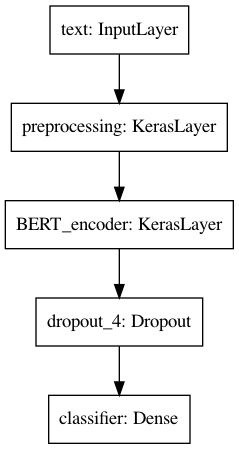

In [114]:
tf.keras.utils.plot_model(classifier_model) # посмотрим на архитектуру модели

In [115]:
# Определим параметры и натренируем модель
EPOCHS = 5
loss = keras.losses.BinaryCrossentropy(from_logits=True)
metrics = keras.metrics.BinaryAccuracy()
optimizer = keras.optimizers.Adam()

classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=EPOCHS)

Epoch 1/5
625/625 [==============================] - 216s 341ms/step - loss: 0.5625 - binary_accuracy: 0.7088 - val_loss: 0.4747 - val_binary_accuracy: 0.7868
Epoch 2/5
625/625 [==============================] - 212s 340ms/step - loss: 0.4674 - binary_accuracy: 0.7847 - val_loss: 0.5015 - val_binary_accuracy: 0.7946
Epoch 3/5
625/625 [==============================] - 214s 343ms/step - loss: 0.4227 - binary_accuracy: 0.8104 - val_loss: 0.5367 - val_binary_accuracy: 0.7590
Epoch 4/5
625/625 [==============================] - 210s 336ms/step - loss: 0.4379 - binary_accuracy: 0.7975 - val_loss: 0.5309 - val_binary_accuracy: 0.7544
Epoch 5/5
625/625 [==============================] - 209s 335ms/step - loss: 0.4061 - binary_accuracy: 0.8152 - val_loss: 0.6330 - val_binary_accuracy: 0.7422


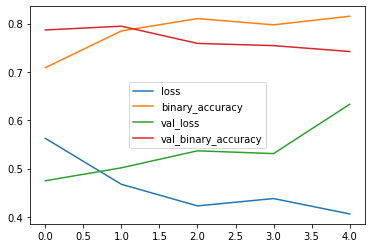

In [116]:
pd.DataFrame(history.history).plot();

In [117]:
loss, accuracy = classifier_model.evaluate(test_ds)

print('Loss: {}'.format(loss))
print('Accuracy: {}'.format(accuracy))

782/782 [==============================] - 74s 95ms/step - loss: 0.6679 - binary_accuracy: 0.7268
Loss: 0.6679204702377319
Accuracy: 0.7267600297927856


In [119]:
def print_my_examples(inputs, results):
    """Функция для вывода предложения и предсказания модели"""
    result_for_printing = ['input: {}.....score: {}'.format(inputs[i], results[i][0]) for i in range(len(inputs))]
    print(*result_for_printing, sep='\n')
    print()

examples = [
    'this is such an amazing movie!',  # Примеры предложений для предсказания
    'The movie was great!',
    'The movie was good.',
    'The movie was okish.',
    'The movie was terrible',
    'Disgusting film',
    'I hate the movie I saw yesterday',
]

results = tf.sigmoid(classifier_model(tf.constant(examples))) # Применяем функцию активации для получения вероятностей

print('Результаты предсказания модели:')
print_my_examples(examples, results)

Результаты предсказания модели:
input: this is such an amazing movie!.....score: 0.9715955257415771
input: The movie was great!.....score: 0.9696699380874634
input: The movie was good......score: 0.373626172542572
input: The movie was okish......score: 0.2939932346343994
input: The movie was terrible.....score: 0.0328637957572937
input: Disgusting film.....score: 0.05736711621284485
input: I hate the movie I saw yesterday.....score: 0.431740939617157

